# Machine Learning and Comic Book Characters
Ariana Olson, Emma Price

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import thinkstats2
import thinkplot

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.models
import keras.layers

import pickle

## Explore the data

In [8]:
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)
    
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)
    
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)

In [9]:
both_df = pd.read_hdf('both_df.hdf5', key='both')
marvel_df = pd.read_hdf('marvel_df.hdf5', key='marvel')
dc_df = pd.read_hdf('dc_df.hdf5', key='dc')

In [10]:
both_df.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,Year,dcmar
0,1678,15641,9764,4.0,1.0,10.0,6.0,4.0,NaN,1.0,4043.0,869.0,1962.0,0
1,7139,2633,1629,3.0,1.0,4.0,25.0,4.0,NaN,1.0,3360.0,1259.0,1941.0,0
2,64786,17911,11142,3.0,2.0,4.0,2.0,4.0,NaN,1.0,3061.0,1486.0,1974.0,0
3,1868,7607,4735,3.0,1.0,4.0,2.0,4.0,NaN,1.0,2961.0,1275.0,1963.0,0
4,2460,16503,10256,2.0,1.0,4.0,3.0,4.0,NaN,1.0,2258.0,1401.0,1950.0,0


In [11]:
both_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18295 entries, 0 to 18294
Data columns (total 14 columns):
page_id             18295 non-null int64
name                18295 non-null int64
urlslug             18295 non-null int64
ID                  14061 non-null float64
ALIGN               16045 non-null float64
EYE                 8496 non-null float64
HAIR                13611 non-null float64
SEX                 17728 non-null float64
GSM                 145 non-null float64
ALIVE               18291 non-null float64
APPEARANCES         17939 non-null float64
FIRST APPEARANCE    17851 non-null float64
Year                17851 non-null float64
dcmar               18295 non-null int64
dtypes: float64(10), int64(4)
memory usage: 2.1 MB


In [12]:
both_df.describe()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,Year,dcmar
count,18295.000000,18295.000000,18295.000000,14061.000000,16045.000000,8496.000000,13611.000000,17728.000000,145.000000,18291.000000,17939.000000,17851.000000,17851.000000,18295.000000
mean,219154.987483,9147.000000,9147.000000,3.409004,0.650545,7.728696,6.942840,3.177177,1.648276,0.754633,22.906517,927.168338,1985.812447,0.376934
std,213972.005972,5281.455923,5281.455923,0.663455,0.695984,6.475668,6.904425,1.340334,0.901627,0.430316,103.055100,394.678077,19.288066,0.484631
min,1025.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1935.000000,0.000000
25%,21599.500000,4573.500000,4573.500000,3.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.000000,2.000000,602.500000,1975.000000,0.000000
50%,154770.000000,9147.000000,9147.000000,4.000000,1.000000,5.000000,3.000000,4.000000,2.000000,1.000000,5.000000,927.000000,1990.000000,0.000000
75%,348820.000000,13720.500000,13720.500000,4.000000,1.000000,8.000000,10.000000,4.000000,2.000000,1.000000,13.000000,1260.000000,2000.000000,1.000000
max,754840.000000,18294.000000,18294.000000,4.000000,3.000000,25.000000,26.000000,5.000000,5.000000,1.000000,4043.000000,1574.000000,2013.000000,1.000000


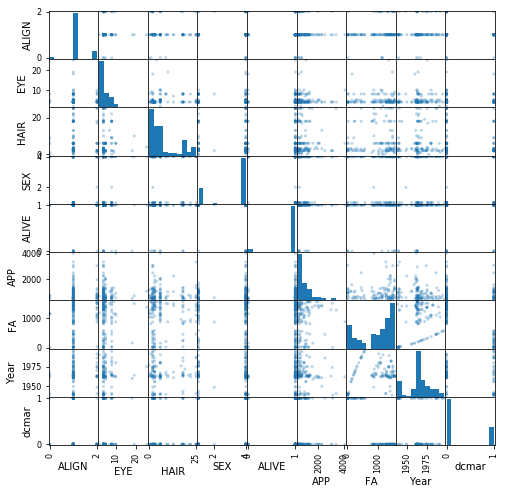

In [14]:
X = both_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','FA','Year', 'dcmar'])
df = df[df['APP']>400]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[8,8])

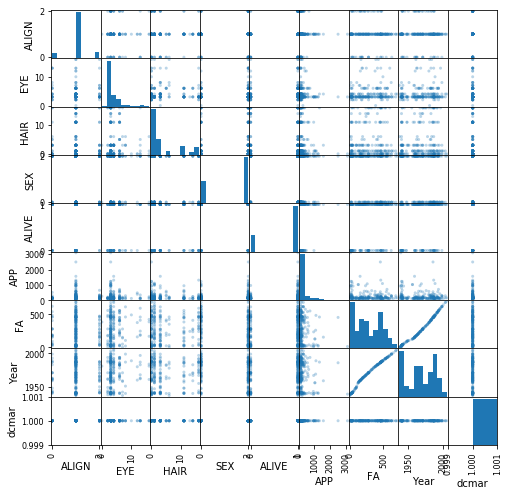

In [16]:
X = dc_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','FA','Year', 'dcmar'])
df = df[df['APP']>100]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[8,8])

/home/eprice/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/home/eprice/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
/home/eprice/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[i])


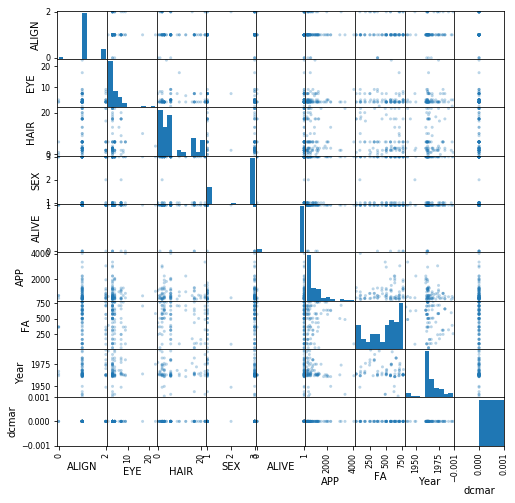

In [17]:
X = marvel_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','FA','Year', 'dcmar'])
df = df[df['APP']>400]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[8,8])

In [14]:
y = both_df.dropna()['FIRST APPEARANCE'].values
X = both_df.dropna().drop(['FIRST APPEARANCE', 'page_id', 'name','urlslug'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

linreg = linear_model.LinearRegression()

linreg.fit(X_train,y_train)

y_pred = linreg.predict(X_test)

print("R^2: {}".format(linreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: -0.29662650459534623
Root Mean Squared Error: 335.2740287731567


In [17]:
y = both_df.dropna()['Year'].values
X = both_df.dropna().drop(['Year', 'page_id', 'name','urlslug'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

linreg = linear_model.LinearRegression()

linreg.fit(X_train,y_train)

y_pred = linreg.predict(X_test)

print("R^2: {}".format(linreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: -0.21643509501953728
Root Mean Squared Error: 13.447765112321617


In [25]:
y = both_df.dropna()['dcmar'].values
X = both_df.dropna().drop(['dcmar', 'page_id', 'name','urlslug'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

y_pred_prob = logreg.predict_proba(X_test)[:,1]

print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))
print(metrics.roc_auc_score(y_test,y_pred_prob))

R^2: 0.9655172413793104
Root Mean Squared Error: 0.18569533817705186
1.0


/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
